In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import os
#import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import joblib
import missingno as msno
warnings.filterwarnings("ignore")
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
#import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
print("Successfully Imported!")

Successfully Imported!


In [3]:
crop_production_data = pd.read_csv("../../Datasets/OpDataset/crop_production_data.csv")
soil_analysis_data = pd.read_csv("../../Datasets/OpDataset/soil_analysis_data.csv")
water_usage_data = pd.read_csv("../../Datasets/OpDataset/water_usage_data.csv")

In [4]:
merge_soil_crop_production_data = crop_production_data.merge(soil_analysis_data, on = ['District'])

In [5]:
merge_water_soil_crop_production_data = merge_soil_crop_production_data.merge(water_usage_data, on = ['District', 'Crop'])

In [6]:
database = merge_water_soil_crop_production_data.copy()

In [7]:
database.head()

,District,Crop,Season,Area (hectares),Yield (quintals),Production (metric tons),Soil Type,pH Level,Organic Matter (%),Nitrogen Content (kg/ha),Phosphorus Content (kg/ha),Potassium Content (kg/ha),Irrigation Method,Water Consumption (liters/hectare),Water Availability (liters/hectare)
0,Jodhpur,Wheat,Kharif,16490.142459,30.691986,5061.15223,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,Sprinkler Irrigation,9738.809833,10557.488279
1,Jodhpur,Wheat,Kharif,16490.142459,30.691986,5061.15223,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,Sprinkler Irrigation,13591.319448,14448.126887
2,Jodhpur,Wheat,Kharif,16490.142459,30.691986,5061.15223,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,Drip Irrigation,8811.686999,8512.323275
3,Jodhpur,Wheat,Kharif,16490.142459,30.691986,5061.15223,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,Sprinkler Irrigation,8860.161716,9434.989877
4,Jodhpur,Wheat,Kharif,16490.142459,30.691986,5061.15223,Chalky (Calcareous),7.305740,2.095212,32.246094,17.450967,40.172205,Sprinkler Irrigation,9738.809833,10557.488279


In [8]:
database = database.drop(columns = ['Production (metric tons)', 'Water Consumption (liters/hectare)'], axis = 1)

In [9]:
database.head()

,District,Crop,Season,Area (hectares),Yield (quintals),Soil Type,pH Level,Organic Matter (%),Nitrogen Content (kg/ha),Phosphorus Content (kg/ha),Potassium Content (kg/ha),Irrigation Method,Water Availability (liters/hectare)
0,Jodhpur,Wheat,Kharif,16490.142459,30.691986,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,Sprinkler Irrigation,10557.488279
1,Jodhpur,Wheat,Kharif,16490.142459,30.691986,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,Sprinkler Irrigation,14448.126887
2,Jodhpur,Wheat,Kharif,16490.142459,30.691986,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,Drip Irrigation,8512.323275
3,Jodhpur,Wheat,Kharif,16490.142459,30.691986,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,Sprinkler Irrigation,9434.989877
4,Jodhpur,Wheat,Kharif,16490.142459,30.691986,Chalky (Calcareous),7.305740,2.095212,32.246094,17.450967,40.172205,Sprinkler Irrigation,10557.488279


Data analysis

In [10]:
database.isnull().sum()

District                               0
Crop                                   0
Season                                 0
Area (hectares)                        0
Yield (quintals)                       0
Soil Type                              0
pH Level                               0
Organic Matter (%)                     0
Nitrogen Content (kg/ha)               0
Phosphorus Content (kg/ha)             0
Potassium Content (kg/ha)              0
Irrigation Method                      0
Water Availability (liters/hectare)    0
dtype: int64

In [11]:
database.duplicated().sum()

0

In [12]:
numerical_cols = ['Area (hectares)', 'pH Level', 'Organic Matter (%)', 'Nitrogen Content (kg/ha)', 'Phosphorus Content (kg/ha)',
       'Potassium Content (kg/ha)', 'Water Availability (liters/hectare)']
categorical_cols = ['District', 'Crop', 'Season', 'Soil Type', 'Irrigation Method']
encoder = OneHotEncoder()
database[categorical_cols] = database[categorical_cols].astype("category")

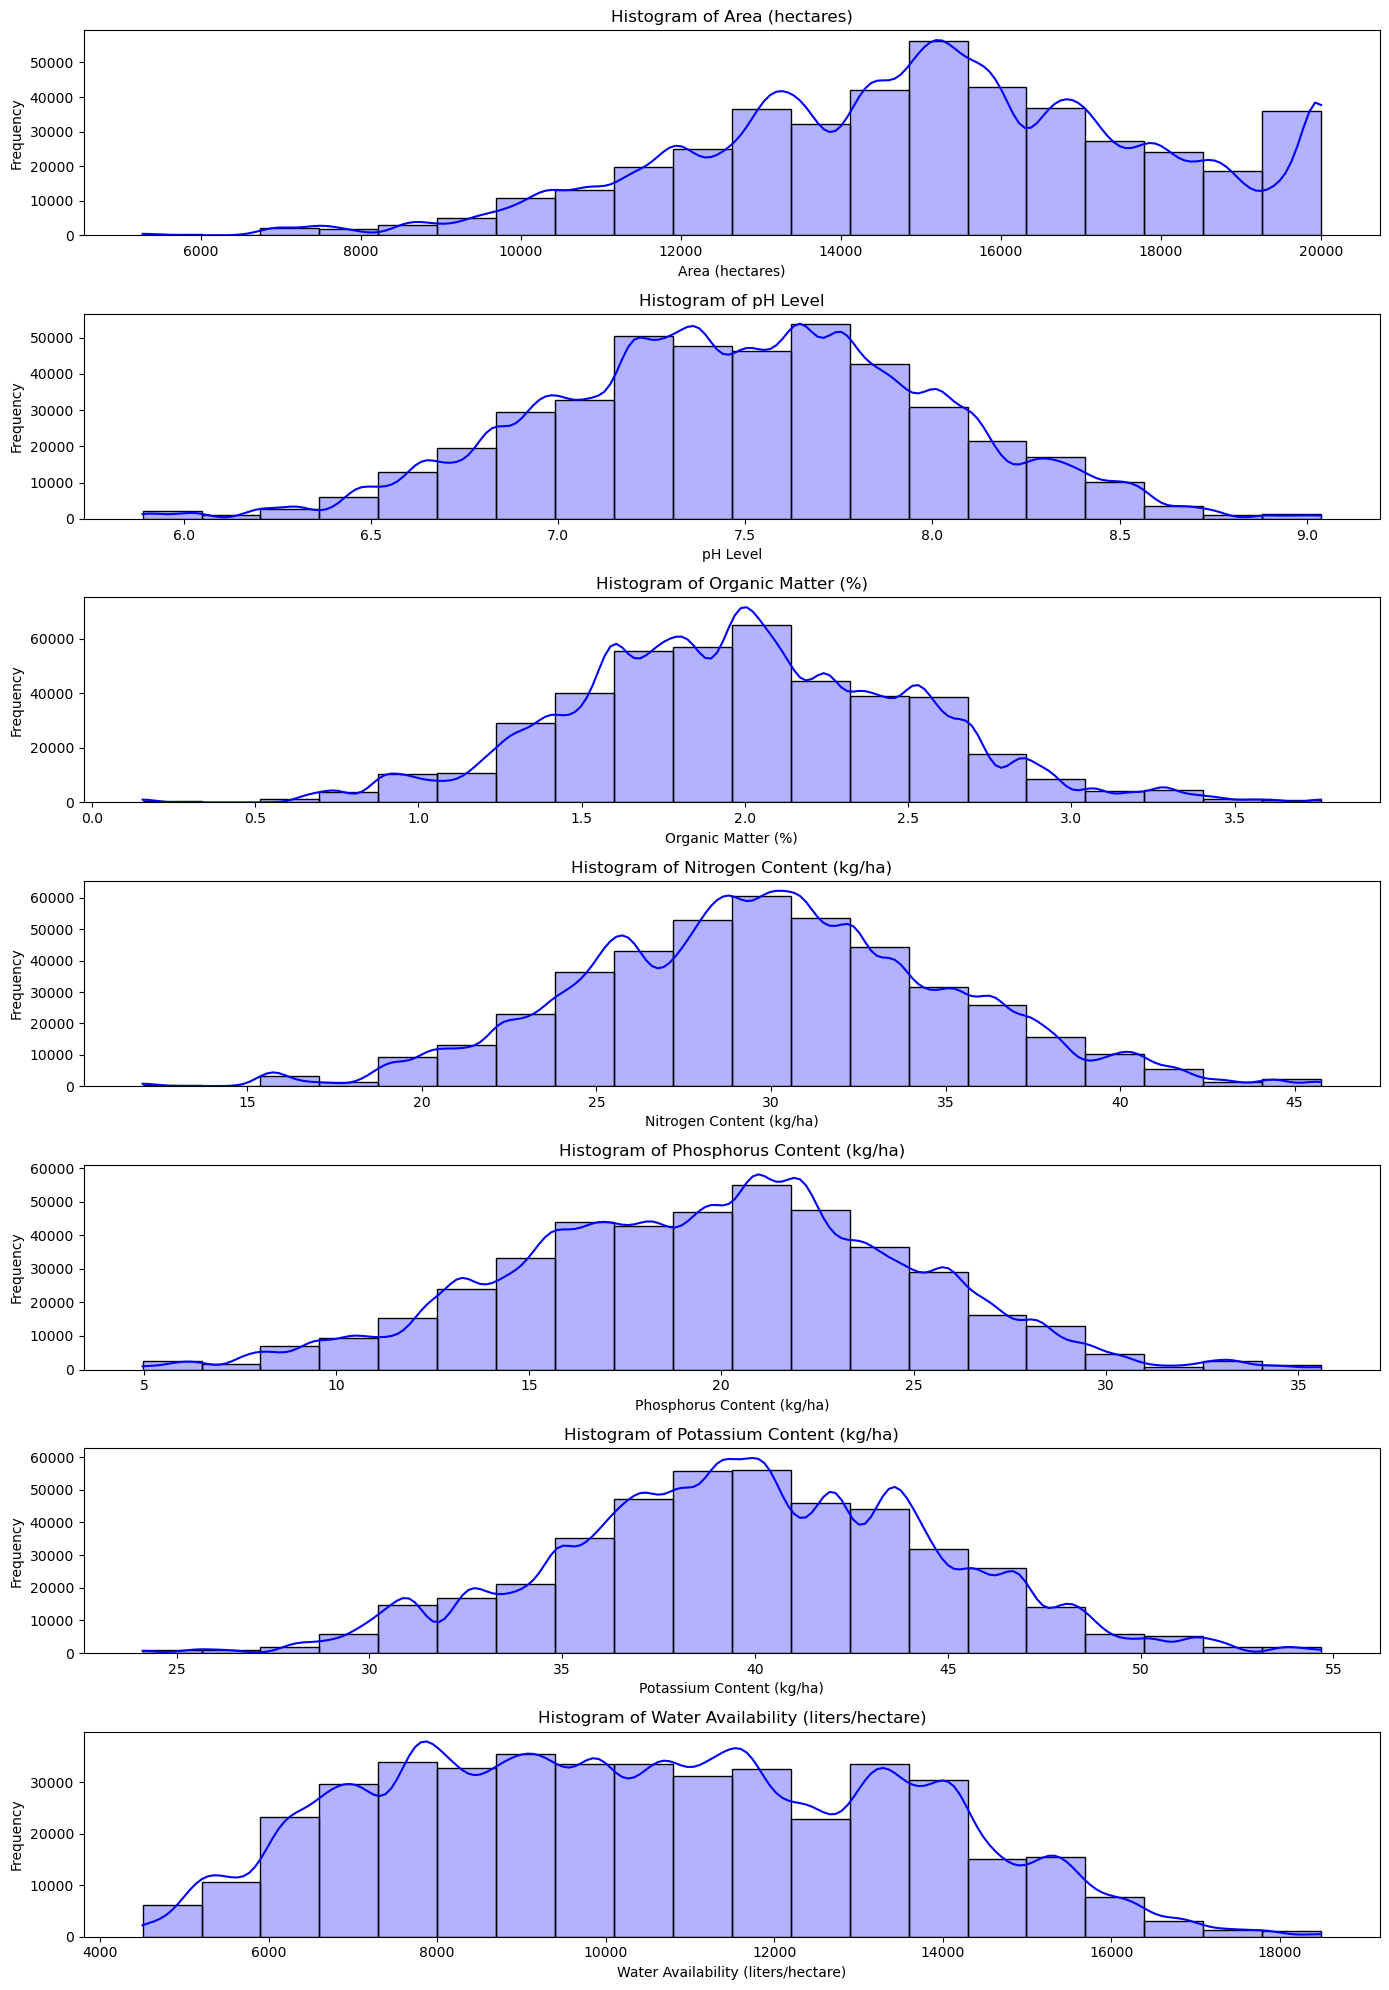

In [15]:
cwd = os.getcwd()
plt.figure(figsize=(14, 20))
for i, col in enumerate(numerical_cols):
    plt.subplot(7, 1, i + 1)
    sns.histplot(database[col], kde=True, color='blue', alpha=0.3, bins=20)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.savefig(os.path.join(cwd, "histogram.png"))
plt.show()

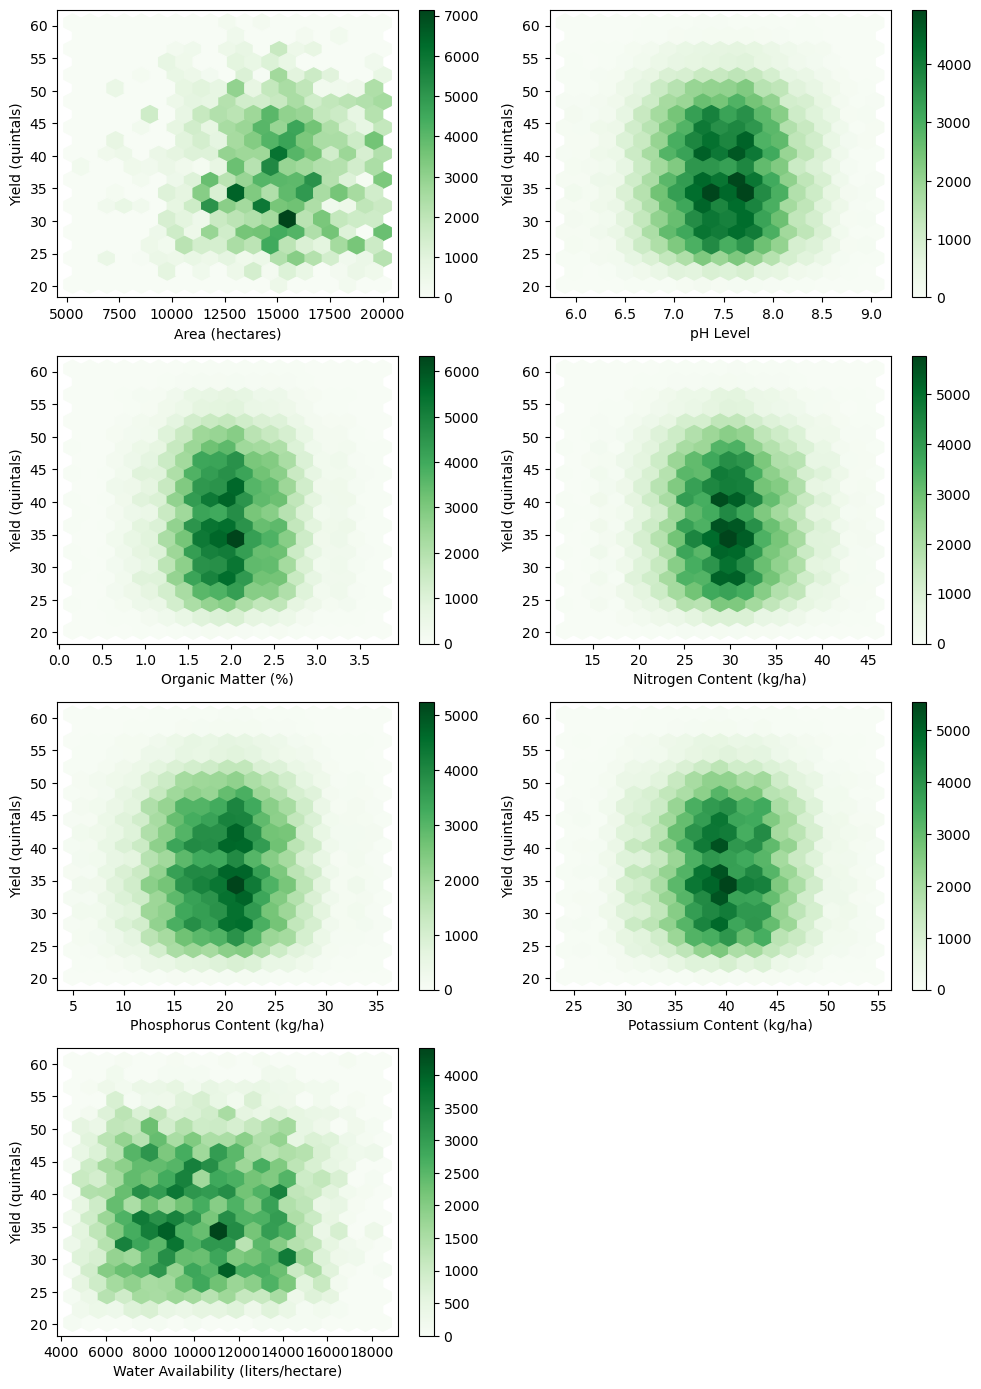

In [55]:
plt.figure(figsize = (10,14))
for i, col in enumerate(numerical_cols):
    ax = plt.subplot(4, 2, i+1)
    database.plot.hexbin(x = col, y = 'Yield (quintals)', gridsize = 18, cmap = 'Greens', ax = ax)
plt.tight_layout()
plt.savefig(os.path.join(cwd, "hexbin.png"))
plt.show()

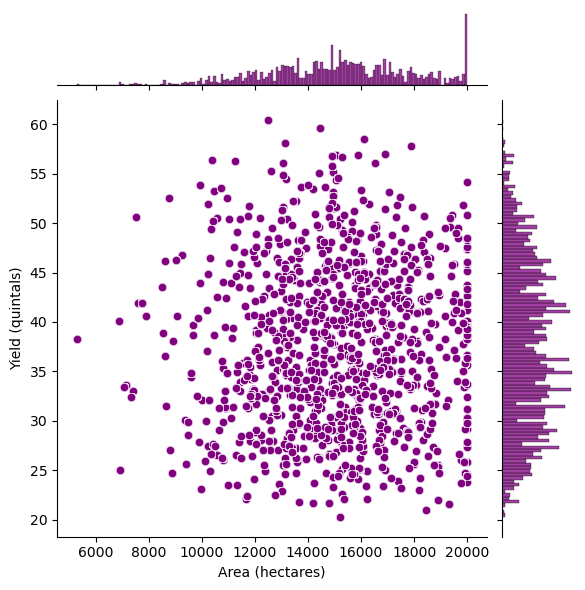

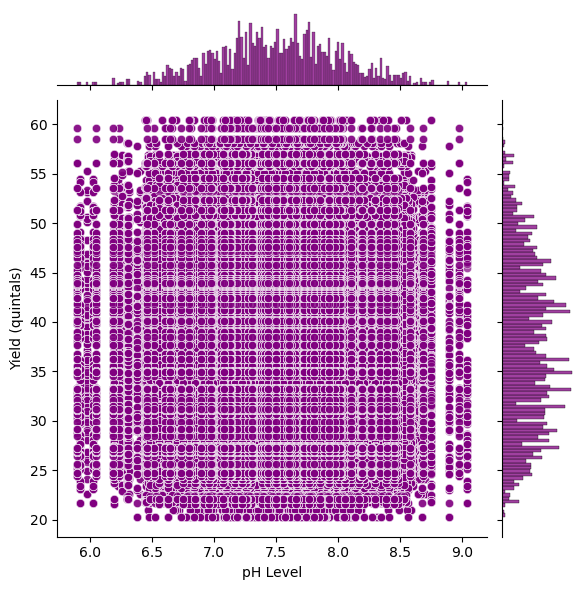

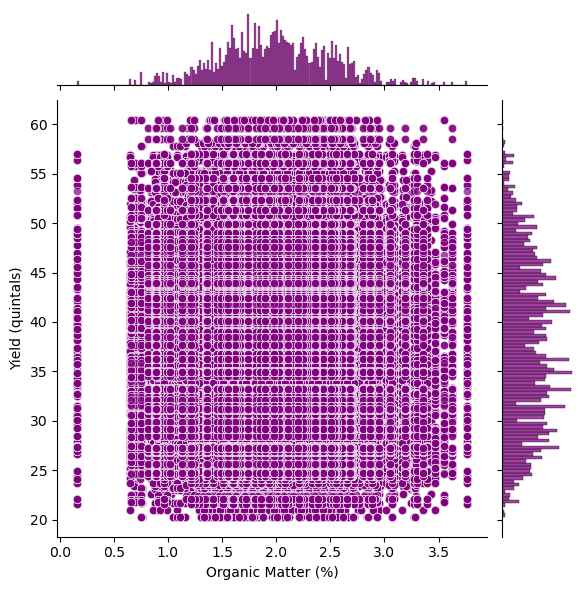

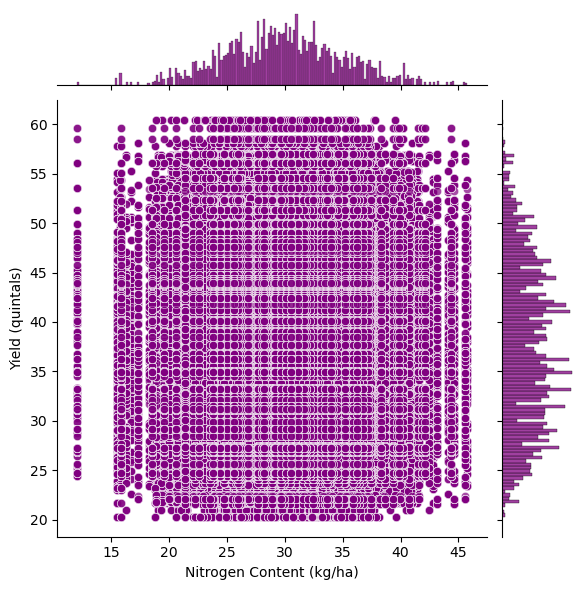

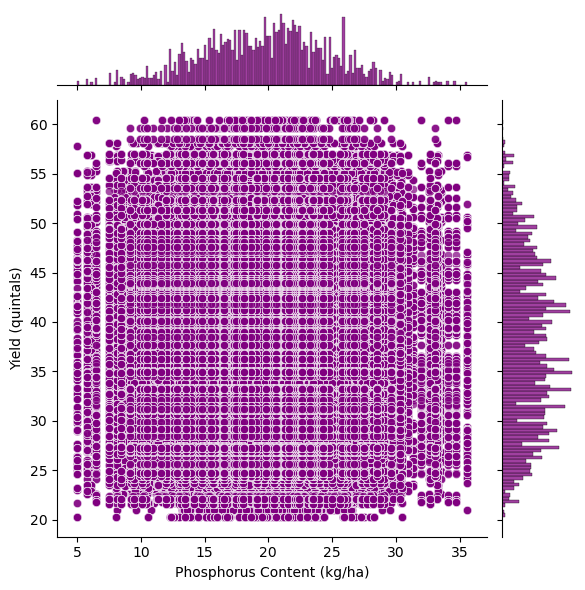

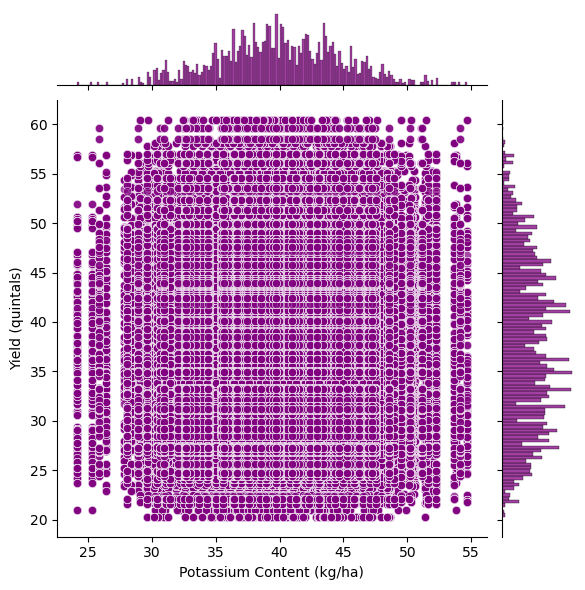

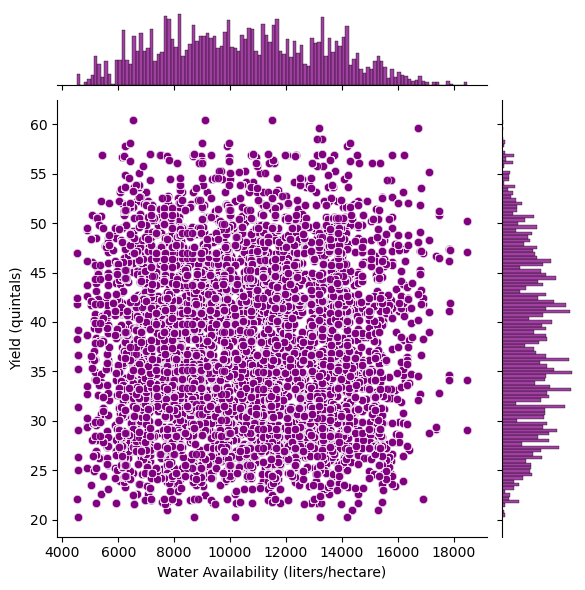

In [56]:
for col in numerical_cols:
    sns.jointplot(x=col, y='Yield (quintals)', data=database, kind='scatter', color='purple', alpha=0.7)
    plt.xlabel(col)
    plt.ylabel('Yield (quintals)')
    plt.show()

In [57]:
X = database.drop(columns=['Yield (quintals)'], axis=1)
y = database['Yield (quintals)']
#two splits to include validation as well
X_train, X_, y_train, y_ = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size = 0.5, random_state = 42)

In [58]:
model = XGBRegressor(tree_method='hist', random_state = 42, enable_categorical=True)
model.fit(X_train, y_train)
joblib.dump(model, 'xgb_model.pkl')

['xgb_model.pkl']

In [59]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

In [60]:
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

print(f"Mean Square Error: {mse_train:.4f}")
print(f"Root Mean Square Error: {rmse_train:.4f}")
print(f"R2 Score: {r2_train:.4f}")

Mean Square Error: 0.2729
Root Mean Square Error: 0.5224
R2 Score: 0.9960


In [61]:
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_val_pred)

print(f"Mean Square Error: {mse_val:.4f}")
print(f"Root Mean Square Error: {rmse_val:.4f}")
print(f"R2 Score: {r2_val:.4f}")

Mean Square Error: 0.2553
Root Mean Square Error: 0.5053
R2 Score: 0.9963


In [62]:
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print(f"Mean Square Error: {mse_test:.4f}")
print(f"Root Mean Square Error: {rmse_test:.4f}")
print(f"R2 Score: {r2_test:.4f}")

Mean Square Error: 0.2851
Root Mean Square Error: 0.5340
R2 Score: 0.9958


In [63]:
params = {'n_estimators': 300, 
               'max_depth': 8, 
               'learning_rate': 0.1, 
               'subsample': 1, 
               'colsample_bytree': 1}

In [64]:
tuned_selection_model = XGBRegressor(**params, random_state = 42, enable_categorical = True, tree_method = "hist")
tuned_selection_model.fit(X_train, y_train, eval_metric = 'rmse', eval_set = [(X_train, y_train), (X_val, y_val)], verbose = False, early_stopping_rounds=10)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [65]:
y_test_tuned_pred = tuned_selection_model.predict(X_test)

In [66]:
mse_test_tuned = mean_squared_error(y_test, y_test_tuned_pred)
rmse_test_tuned = np.sqrt(mse_test_tuned)
r2_test_tuned = r2_score(y_test, y_test_tuned_pred)

print(f"Tuned Model - Test Set\nMean Square Error: {mse_test_tuned:.4f}")
print(f"Root Mean Square Error: {rmse_test_tuned:.4f}")
print(f"R2 Score: {r2_test_tuned:.4f}")

Tuned Model - Test Set
Mean Square Error: 0.1293
Root Mean Square Error: 0.3596
R2 Score: 0.9981


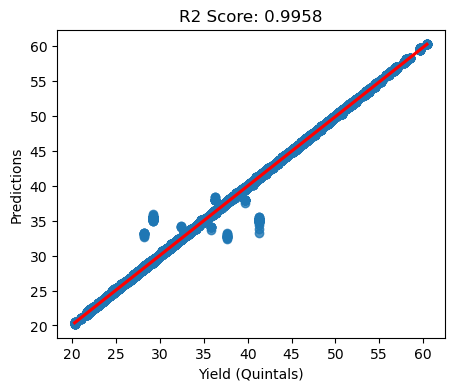

In [67]:
plt.figure(figsize = (5,4))
sns.regplot(x = y_test, y = y_test_tuned_pred, line_kws = {'color':'red'})
plt.xlabel("Yield (Quintals)")
plt.ylabel("Predictions")
plt.title(f"R2 Score: {r2_test:.4f}")
plt.savefig(os.path.join(cwd, "Rsquared.png"))
plt.show()

In [68]:
#tuned_selection_model.save_model('xgboost_model.json')

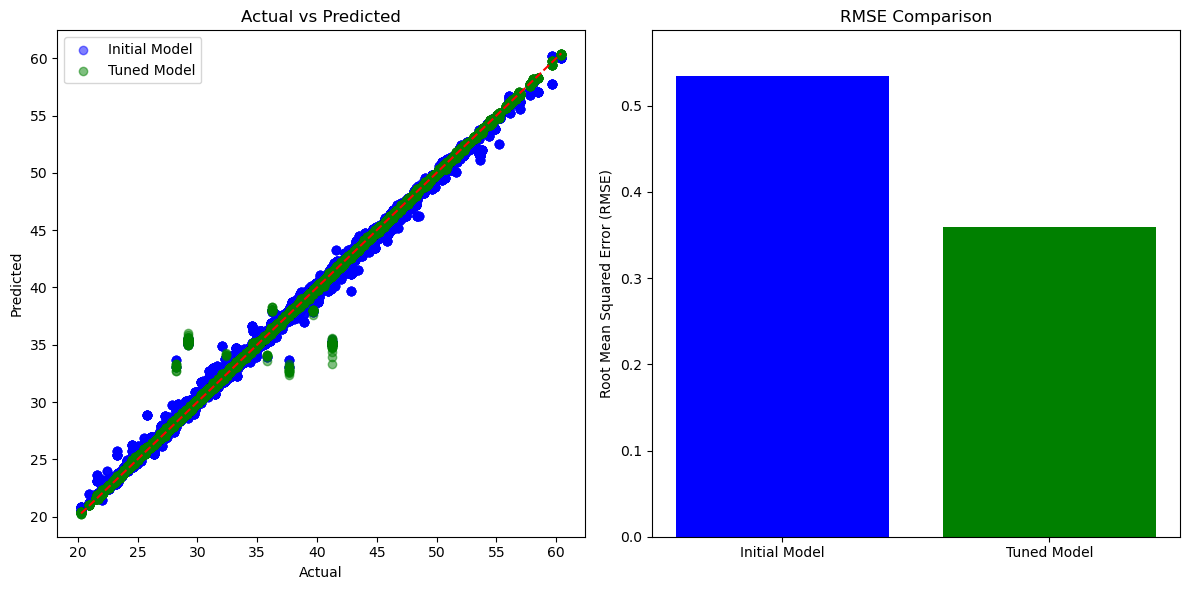

In [69]:
plt.figure(figsize=(12, 6))

# Scatter plot of actual vs. predicted values for the test set
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5, color='blue', label='Initial Model')
plt.scatter(y_test, y_test_tuned_pred, alpha=0.5, color='green', label='Tuned Model')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

# Bar plot of RMSE comparison
errors = {
    'Initial Model': rmse_test,
    'Tuned Model': rmse_test_tuned
}
plt.subplot(1, 2, 2)
plt.bar(errors.keys(), errors.values(), color=['blue', 'green'])
plt.title('RMSE Comparison')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.ylim(0, max(errors.values()) * 1.1)  # Adjust y-axis for better visualization

plt.tight_layout()
plt.savefig(os.path.join(cwd, "model_comparison.png"))
plt.show()

In [70]:
metrics_df = pd.DataFrame({
    'Set': ['Training', 'Validation', 'Test'],
    'MSE': [mse_train, mse_val, mse_test],
    'RMSE': [rmse_train, rmse_val, rmse_test],
    'R2 Score': [r2_train, r2_val, r2_test]
})

# Display the DataFrame
metrics_df

,Set,MSE,RMSE,R2 Score
0,Training,0.272888,0.522387,0.996001
1,Validation,0.255337,0.505308,0.996255
2,Test,0.285136,0.533981,0.995844


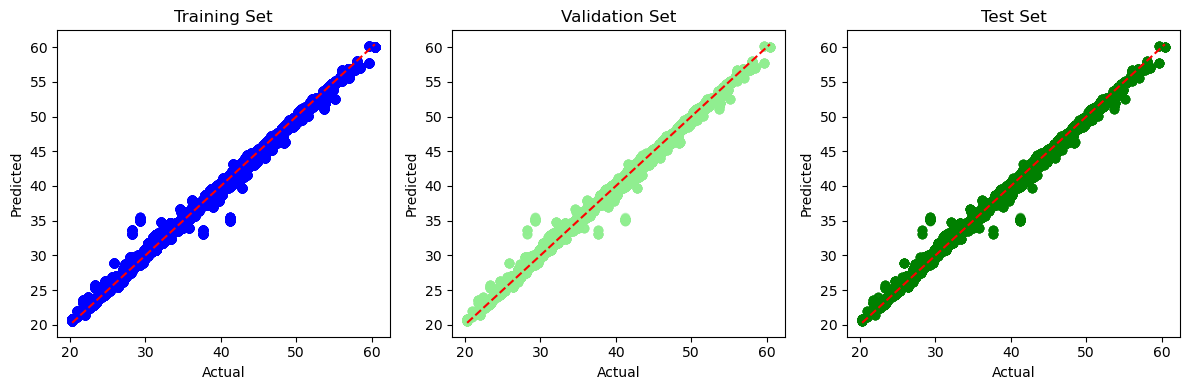

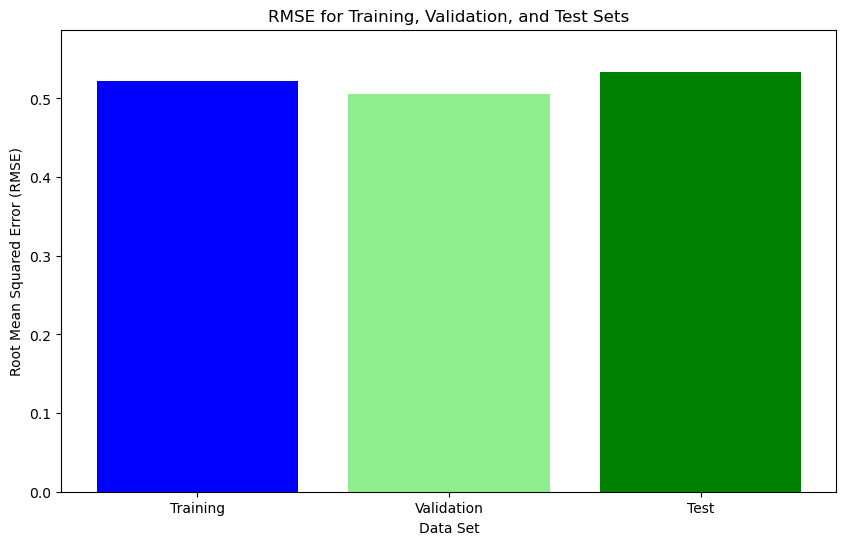

In [71]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.title('Training Set')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Plotting predictions vs actual values for validation set
plt.subplot(1, 3, 2)
plt.scatter(y_val, y_val_pred, alpha=0.5, color='lightgreen')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title('Validation Set')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Plotting predictions vs actual values for test set
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_test_pred, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Test Set')
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.tight_layout()
plt.savefig(os.path.join(cwd, "error.png"))

errors = {
    'Training': rmse_train,
    'Validation': rmse_val,
    'Test': rmse_test
}

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(errors.keys(), errors.values(), color=['blue', 'lightgreen', 'green'])
plt.title('RMSE for Training, Validation, and Test Sets')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xlabel('Data Set')
plt.ylim(0, max(errors.values()) * 1.1)  # Adjust y-axis for better visualization
plt.savefig(os.path.join(cwd, "errors_compared.png"))
plt.show()

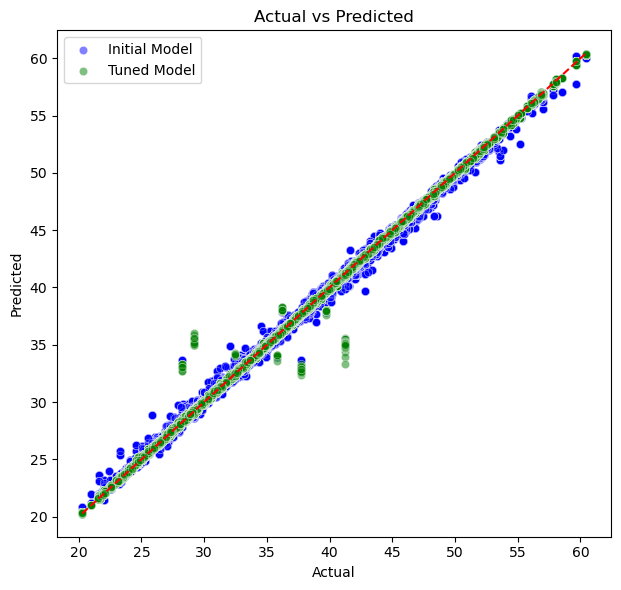

In [78]:
plt.figure(figsize=(12, 6))

# Scatter plot of actual vs. predicted values for the test set
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.5, color='blue', label='Initial Model')
sns.scatterplot(x=y_test, y=y_test_tuned_pred, alpha=0.5, color='green', label='Tuned Model')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()

plt.tight_layout()  # Adjust the layout

# Save the figure with the adjusted layout
plt.savefig(os.path.join(cwd, "initial_vs_tuned.png"))

# Show the plot
plt.show()

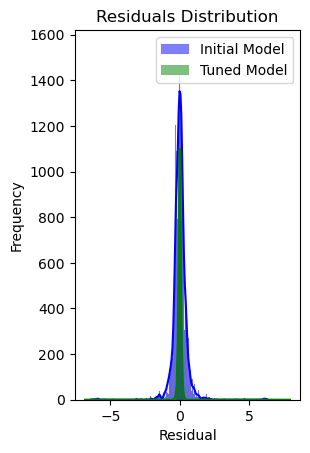

In [74]:
plt.subplot(1, 2, 2)
residuals_initial = y_test - y_test_pred
residuals_tuned = y_test - y_test_tuned_pred
sns.histplot(residuals_initial, color='blue', label='Initial Model', kde=True, alpha=0.5)
sns.histplot(residuals_tuned, color='green', label='Tuned Model', kde=True, alpha=0.5)
plt.title('Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.legend()

<Figure size 640x480 with 0 Axes>

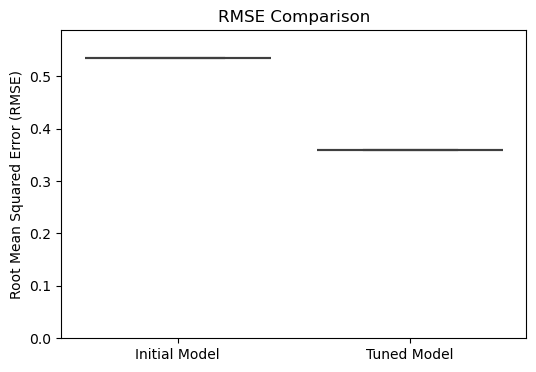

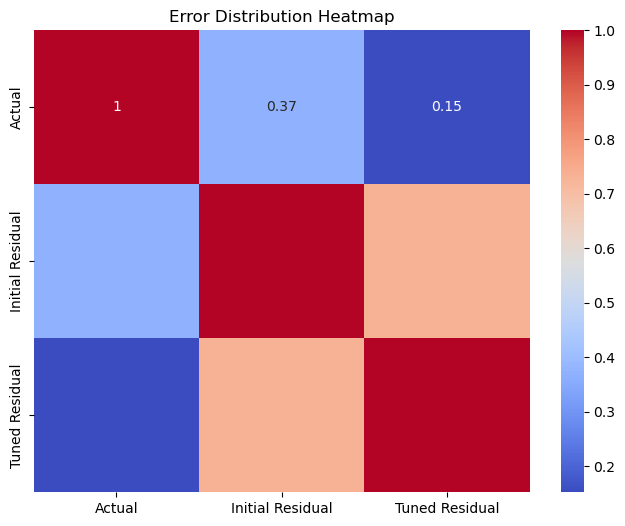

In [75]:
plt.tight_layout()
plt.savefig(os.path.join(cwd, "actual_vs_predicted_and_residuals.png"))
plt.show()

# Box Plot of RMSE
plt.figure(figsize=(6, 4))
rmse_data = {
    'Initial Model': [rmse_test],
    'Tuned Model': [rmse_test_tuned]
}
rmse_df = pd.DataFrame(rmse_data)
sns.boxplot(data=rmse_df)
plt.title('RMSE Comparison')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.ylim(0, max(errors.values()) * 1.1)
plt.savefig(os.path.join(cwd, "rmse_comparison.png"))
plt.show()

# Heatmap for Error Distribution
plt.figure(figsize=(8, 6))
error_distribution = pd.DataFrame({
    'Actual': y_test,
    'Initial Residual': residuals_initial,
    'Tuned Residual': residuals_tuned
})
sns.heatmap(error_distribution.corr(), annot=True, cmap='coolwarm')
plt.title('Error Distribution Heatmap')
plt.savefig(os.path.join(cwd, "error_distribution_heatmap.png"))
plt.show()